# Прогнозирование стоимости недвижимости в Нью-Йорке

## Цель проекта
В рамках данного проекта исследуются различные подходы к машинному обучению для решения задачи регрессии - прогнозирования стоимости аренды квартир в Нью-Йорке. 

**Источник данных:** [Kaggle - New York City Apartment Rental Prices](https://www.kaggle.com/datasets/new-york-city-apartment-rental-prices)



# Введение

## Импорты и загрузка данных

Для начала загрузим необходимые библиотеки.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures

Загружаем наши датасеты и сразу делаем первый визуальный обзор распределения цен.

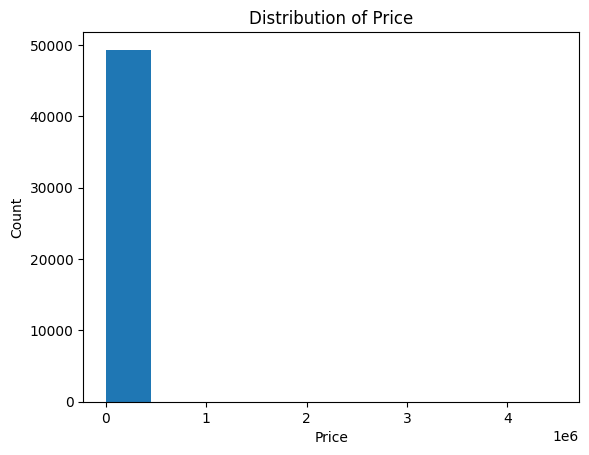

In [3]:
train = pd.read_json("data/train.json")
test = pd.read_json("data/train.json")
plt.hist(train["price"])
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of Price")
plt.show()

На гистограмме видно, что данные сильно скошены из-за выбросов. Нужно обработать экстремальные значения, чтобы модели работали корректнее.

Удаляем экстремальные значения цен (1-й и 99-й перцентили) и преобразуем категориальный признак `interest_level` в числовой формат для удобства работы моделей.

In [4]:
low = train['price'].quantile(0.01)
high = train['price'].quantile(0.99)

train = train[(train['price'] >= low) & (train['price'] <= high)]
train['interest_level'] = train['interest_level'].map({'low': 0, 'medium': 1, 'high': 2})

low = test['price'].quantile(0.01)
high = test['price'].quantile(0.99)

test = test[(test['price'] >= low) & (test['price'] <= high)]


Проверяем распределения цен после очистки

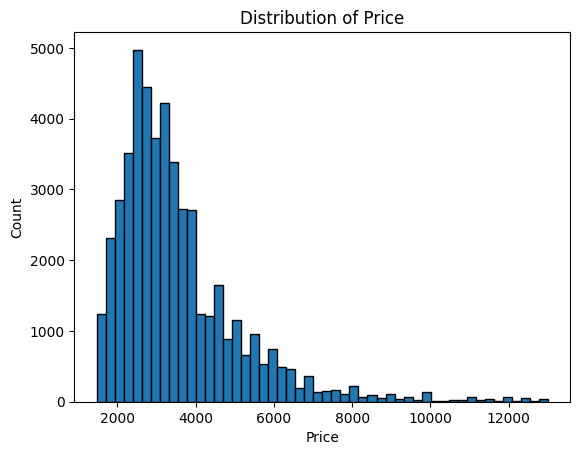

In [5]:
plt.hist(train["price"],bins=50,edgecolor='black')
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of Price")
plt.show()

После удаления выбросов распределение цен стало более симметричным, что улучшает обучение моделей.

# Создание и кодирование признаков для модели

Смотрим на исходный список признаков квартир. Заметим, что они представлены в виде списков строк.

In [6]:
train["features"]

4         [Dining Room, Pre-War, Laundry in Building, Di...
6         [Doorman, Elevator, Laundry in Building, Dishw...
9         [Doorman, Elevator, Laundry in Building, Laund...
10                                                       []
15        [Doorman, Elevator, Fitness Center, Laundry in...
                                ...                        
124000              [Elevator, Dishwasher, Hardwood Floors]
124002    [Common Outdoor Space, Cats Allowed, Dogs Allo...
124004    [Dining Room, Elevator, Pre-War, Laundry in Bu...
124008    [Pre-War, Laundry in Unit, Dishwasher, No Fee,...
124009    [Dining Room, Elevator, Laundry in Building, D...
Name: features, Length: 48379, dtype: object

Убираем лишние символы из строк признаков для удобной работы и анализа.

In [7]:
train['features'] = train['features'].apply(lambda lst: [f.replace("[","").replace("]","").replace("'","").replace('"',"").replace(" ","") for f in lst])

test['features'] = test['features'].apply(lambda lst: [f.replace("[","").replace("]","").replace("'","").replace('"',"").replace(" ","") for f in lst])

train["features"]


4         [DiningRoom, Pre-War, LaundryinBuilding, Dishw...
6         [Doorman, Elevator, LaundryinBuilding, Dishwas...
9         [Doorman, Elevator, LaundryinBuilding, Laundry...
10                                                       []
15        [Doorman, Elevator, FitnessCenter, LaundryinBu...
                                ...                        
124000               [Elevator, Dishwasher, HardwoodFloors]
124002    [CommonOutdoorSpace, CatsAllowed, DogsAllowed,...
124004    [DiningRoom, Elevator, Pre-War, LaundryinBuild...
124008    [Pre-War, LaundryinUnit, Dishwasher, NoFee, Ou...
124009    [DiningRoom, Elevator, LaundryinBuilding, Dish...
Name: features, Length: 48379, dtype: object

Объединяем признаки всех квартир в один список для подсчета встречаемости каждого признака.

In [36]:
all_features = []

for _, row in train.iterrows():
    all_features.extend(row['features'])
    
all_features[:10]

['DiningRoom',
 'Pre-War',
 'LaundryinBuilding',
 'Dishwasher',
 'HardwoodFloors',
 'DogsAllowed',
 'CatsAllowed',
 'Doorman',
 'Elevator',
 'LaundryinBuilding']

Считаем, сколько всего уникальных признаков присутствует в датасете.

In [9]:
unique_features = set(all_features)
len(unique_features)

1529

Определяем самые популярные признаки, чтобы в дальнейшем использовать их как отдельные бинарные признаки в моделях.

In [10]:
top20 = [feature for feature, count in Counter(all_features).most_common(20)]
top20

['Elevator',
 'HardwoodFloors',
 'CatsAllowed',
 'DogsAllowed',
 'Doorman',
 'Dishwasher',
 'NoFee',
 'LaundryinBuilding',
 'FitnessCenter',
 'Pre-War',
 'LaundryinUnit',
 'RoofDeck',
 'OutdoorSpace',
 'DiningRoom',
 'HighSpeedInternet',
 'Balcony',
 'SwimmingPool',
 'LaundryInBuilding',
 'NewConstruction',
 'Terrace']

## Формирование признаков для моделей
Создаем отдельные таблицы признаков для обучения и теста.  

In [11]:
train_features = pd.DataFrame()

test_features = pd.DataFrame()


- Сохраняем количественные признаки: количество ванных и спален.  
- Для топ-20 наиболее популярных признаков создаем бинарные колонки: 1, если квартира обладает этим признаком, 0 — иначе.  

Такой подход позволяет напрямую использовать признаки в линейной регрессии.

In [12]:
train_features['bathrooms'] = train['bathrooms']
train_features['bedrooms'] = train['bedrooms']
test_features['bathrooms'] = test['bathrooms']
test_features['bedrooms'] = test['bedrooms']

for f in top20:
    train_features[f] = train['features'].apply(lambda lst: 1 if f in lst else 0)
    test_features[f] = test['features'].apply(lambda lst: 1 if f in lst else 0)

train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48379 entries, 4 to 124009
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bathrooms          48379 non-null  float64
 1   bedrooms           48379 non-null  int64  
 2   Elevator           48379 non-null  int64  
 3   HardwoodFloors     48379 non-null  int64  
 4   CatsAllowed        48379 non-null  int64  
 5   DogsAllowed        48379 non-null  int64  
 6   Doorman            48379 non-null  int64  
 7   Dishwasher         48379 non-null  int64  
 8   NoFee              48379 non-null  int64  
 9   LaundryinBuilding  48379 non-null  int64  
 10  FitnessCenter      48379 non-null  int64  
 11  Pre-War            48379 non-null  int64  
 12  LaundryinUnit      48379 non-null  int64  
 13  RoofDeck           48379 non-null  int64  
 14  OutdoorSpace       48379 non-null  int64  
 15  DiningRoom         48379 non-null  int64  
 16  HighSpeedInternet  48

In [13]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48379 entries, 4 to 124009
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bathrooms          48379 non-null  float64
 1   bedrooms           48379 non-null  int64  
 2   Elevator           48379 non-null  int64  
 3   HardwoodFloors     48379 non-null  int64  
 4   CatsAllowed        48379 non-null  int64  
 5   DogsAllowed        48379 non-null  int64  
 6   Doorman            48379 non-null  int64  
 7   Dishwasher         48379 non-null  int64  
 8   NoFee              48379 non-null  int64  
 9   LaundryinBuilding  48379 non-null  int64  
 10  FitnessCenter      48379 non-null  int64  
 11  Pre-War            48379 non-null  int64  
 12  LaundryinUnit      48379 non-null  int64  
 13  RoofDeck           48379 non-null  int64  
 14  OutdoorSpace       48379 non-null  int64  
 15  DiningRoom         48379 non-null  int64  
 16  HighSpeedInternet  48

# Реализация собственной линейной регрессии

В этом блоке я создаю класс `MyLinearRegression`, который позволяет обучать модель линейной регрессии тремя способами:
- аналитическое решение (нормальное уравнение),
- градиентный спуск,
- стохастический градиентный спуск.

Также реализованы методы для расчета метрик: MAE, MSE и R².

In [14]:
class MyLinearRegression:
    def __init__(self, method='analytical', eta=0.01, N=1000, random_state=21):
        self.w = None
        self.method = method
        self.eta = eta
        self.N = N
        self.random_state = random_state

    def fit(self, X, y):
        np.random.seed(self.random_state)
        X = np.c_[np.ones((X.shape[0], 1)), X]
        self.w = np.zeros(X.shape[1])

        
        if self.method == 'analytical':
            # Аналитическое решение (нормальное уравнение)
            self.w = np.linalg.inv(X.T @ X) @ X.T @ y


        elif self.method == 'gd':
            # Обычный градиентный спуск
            self.w = np.zeros(X.shape[1])
            for _ in range(self.N):
                grad = - (1/len(y)) * X.T @ (y - X @ self.w)
                self.w = self.w - self.eta * grad
                

        elif self.method == 'sgd':
            # Стохастический градиентный спуск
            self.w = np.zeros(X.shape[1])
            for _ in range(self.N):
                k = np.random.randint(0, len(X))
                x_k = X[k]
                y_k = y[k]
                y_pred = self.w @ x_k.T
                grad = - (y_k - y_pred) * x_k
                self.w = self.w - self.eta * grad

    def predict(self, X):
        X = np.c_[np.ones((X.shape[0], 1)), X]
        return X @ self.w
    
    def MAE(self, y, y_pred):
        Q = np.mean(np.abs(y_pred - y))
        return Q
    
    def MSE(self, y, y_pred):
         Q = np.mean((y_pred - y)**2)
         return Q
     
    def r2_score(self, y, y_pred):
        y_mean = np.mean(y)
        SS_res  = np.sum((y_pred - y)**2)
        SS_tot = np.sum((y - y_mean)**2)
        R = 1 - SS_res/SS_tot
        return R

Создаем пустые DataFrame для хранения метрик MAE, RMSE и R² для обучающих и тестовых данных.

In [15]:
columns = ['model', 'train', 'test']

result_MAE = pd.DataFrame(columns=columns)
result_RMSE = pd.DataFrame(columns=columns)
result_R2 = pd.DataFrame(columns=columns)

Дальше мы обучаем несколько реализаций моей линейной регрессии (аналитическое решение, градиентный спуск, стохастический градиентный спуск) и стандартную модель LinearRegression из sklearn. Затем считаем метрики качества: MAE, RMSE и R² для обучающих и тестовых данных и сохраняем результаты в таблицы.

In [16]:
# Сбрасываем индексы, чтобы X и y точно соответствовали друг другу
X_train = train_features.reset_index(drop=True)
y_train = train['price'].reset_index(drop=True)

X_test = test_features.reset_index(drop=True)
y_test = test['price'].reset_index(drop=True)

# 1. Обучаем модели MyLinearRegression

# Аналитическое решение
my_lr_analytical = MyLinearRegression()
my_lr_analytical.fit(X_train, y_train)  # обучение
y_train_pred_my_analytical = my_lr_analytical.predict(X_train)  # предсказания на train
y_test_pred_my_analytical = my_lr_analytical.predict(X_test)    # предсказания на test

# Градиентный спуск
my_lr_gd = MyLinearRegression(method="gd")
my_lr_gd.fit(X_train, y_train)
y_train_pred_my_gd = my_lr_gd.predict(X_train)
y_test_pred_my_gd = my_lr_gd.predict(X_test)

# Стохастический градиентный спуск
my_lr_sgd = MyLinearRegression(method="sgd")
my_lr_sgd.fit(X_train, y_train)
y_train_pred_my_sgd = my_lr_sgd.predict(X_train)
y_test_pred_my_sgd = my_lr_sgd.predict(X_test)

# 2. Обучаем модель sklearn
sk_lr = LinearRegression()
sk_lr.fit(X_train, y_train)
y_train_pred_sk = sk_lr.predict(X_train) 
y_test_pred_sk = sk_lr.predict(X_test) 

# 3. Считаем MAE (Mean Absolute Error)
mae_my_analytical_train = my_lr_analytical.MAE(y_train, y_train_pred_my_analytical)
mae_my_analytical_test = my_lr_analytical.MAE(y_test, y_test_pred_my_analytical)
mae_my_gd_train = my_lr_gd.MAE(y_train, y_train_pred_my_gd)
mae_my_gd_test = my_lr_gd.MAE(y_test, y_test_pred_my_gd)
mae_my_sgd_train = my_lr_sgd.MAE(y_train, y_train_pred_my_sgd)
mae_my_sgd_test = my_lr_sgd.MAE(y_test, y_test_pred_my_sgd)

mae_sk_train = mean_absolute_error(y_train, y_train_pred_sk)
mae_sk_test = mean_absolute_error(y_test, y_test_pred_sk)

# Сохраняем результаты в таблицу
result_MAE = result_MAE.append({'model':'my_lr_analytical','train':mae_my_analytical_train,'test':mae_my_analytical_test}, ignore_index=True)
result_MAE = result_MAE.append({'model':'my_lr_gd','train':mae_my_gd_train,'test':mae_my_gd_test}, ignore_index=True)
result_MAE = result_MAE.append({'model':'my_lr_sgd','train':mae_my_sgd_train,'test':mae_my_sgd_test}, ignore_index=True)
result_MAE = result_MAE.append({'model':'sk_lr','train':mae_sk_train,'test':mae_sk_test}, ignore_index=True)

# 4. Считаем RMSE (Root Mean Squared Error)
rmse_my_analytical_train = np.sqrt(my_lr_analytical.MSE(y_train, y_train_pred_my_analytical))
rmse_my_analytical_test = np.sqrt(my_lr_analytical.MSE(y_test, y_test_pred_my_analytical))
rmse_my_gd_train = np.sqrt(my_lr_gd.MSE(y_train, y_train_pred_my_gd))
rmse_my_gd_test = np.sqrt(my_lr_gd.MSE(y_test, y_test_pred_my_gd))
rmse_my_sgd_train = np.sqrt(my_lr_sgd.MSE(y_train, y_train_pred_my_sgd))
rmse_my_sgd_test = np.sqrt(my_lr_sgd.MSE(y_test, y_test_pred_my_sgd))

rmse_sk_train = np.sqrt(mean_squared_error(y_train, y_train_pred_sk))
rmse_sk_test = np.sqrt(mean_squared_error(y_test, y_test_pred_sk))

# Сохраняем результаты в таблицу
result_RMSE = result_RMSE.append({'model':'my_lr_analytical','train':rmse_my_analytical_train,'test':rmse_my_analytical_test}, ignore_index=True)
result_RMSE = result_RMSE.append({'model':'my_lr_gd','train':rmse_my_gd_train,'test':rmse_my_gd_test}, ignore_index=True)
result_RMSE = result_RMSE.append({'model':'my_lr_sgd','train':rmse_my_sgd_train,'test':rmse_my_sgd_test}, ignore_index=True)
result_RMSE = result_RMSE.append({'model':'sk_lr','train':rmse_sk_train,'test':rmse_sk_test}, ignore_index=True)

# 5. Считаем R2 (коэффициент детерминации)
r2_score_my_analytical_train = my_lr_analytical.r2_score(y_train, y_train_pred_my_analytical)
r2_score_my_analytical_test = my_lr_analytical.r2_score(y_test, y_test_pred_my_analytical)
r2_score_my_gd_train = my_lr_gd.r2_score(y_train, y_train_pred_my_gd)
r2_score_my_gd_test = my_lr_gd.r2_score(y_test, y_test_pred_my_gd)
r2_score_my_sgd_train = my_lr_sgd.r2_score(y_train, y_train_pred_my_sgd)
r2_score_my_sgd_test = my_lr_sgd.r2_score(y_test, y_test_pred_my_sgd)

r2_score_sk_train = r2_score(y_train, y_train_pred_sk)
r2_score_sk_test = r2_score(y_test, y_test_pred_sk)

# Сохраняем результаты в таблицу
result_R2 = result_R2.append({'model':'my_lr_analytical','train':r2_score_my_analytical_train,'test':r2_score_my_analytical_test}, ignore_index=True)
result_R2 = result_R2.append({'model':'my_lr_gd','train':r2_score_my_gd_train,'test':r2_score_my_gd_test}, ignore_index=True)
result_R2 = result_R2.append({'model':'my_lr_sgd','train':r2_score_my_sgd_train,'test':r2_score_my_sgd_test}, ignore_index=True)
result_R2 = result_R2.append({'model':'sk_lr','train':r2_score_sk_train,'test':r2_score_sk_test}, ignore_index=True)

Рассмотрим результаты наших моделей на тренировочных и тестовых данных с помощью метрик:

- **MAE (Mean Absolute Error)** – средняя абсолютная ошибка  
- **RMSE (Root Mean Squared Error)** – корень из средней квадратичной ошибки  
- **R² (коэффициент детерминации)** – насколько модель объясняет вариацию данных  

Из таблиц видно, что аналитическое решение и модель из `sklearn` показывают идентичные результаты и работают лучше, чем градиентный спуск и стохастический градиентный спуск.

In [17]:
print("MAE:\n", result_MAE)
print("\nRMSE:\n", result_RMSE)
print("\nR2:\n", result_R2)

MAE:
               model       train        test
0  my_lr_analytical  711.791166  711.791166
1          my_lr_gd  714.463226  714.463226
2         my_lr_sgd  728.708311  728.708311
3             sk_lr  711.791166  711.791166

RMSE:
               model        train         test
0  my_lr_analytical  1035.351576  1035.351576
1          my_lr_gd  1042.960536  1042.960536
2         my_lr_sgd  1118.130926  1118.130926
3             sk_lr  1035.351576  1035.351576

R2:
               model     train      test
0  my_lr_analytical  0.580034  0.580034
1          my_lr_gd  0.573838  0.573838
2         my_lr_sgd  0.510194  0.510194
3             sk_lr  0.580034  0.580034


# Линейная регрессия с регуляризацией

Здесь мы расширяем класс линейной регрессии, добавляя возможность использовать разные виды регуляризации:

- **Ridge (L2)** – штрафует большие коэффициенты, помогает бороться с переобучением.
- **Lasso (L1)** – способствует разреженности коэффициентов, автоматически выбирает признаки.
- **ElasticNet** – сочетает L1 и L2, объединяя их преимущества.

Метод `fit` теперь учитывает выбранный тип регуляризации и соответствующий коэффициент `alpha`.  
Для градиентного спуска и стохастического градиентного спуска штраф добавляется в вычисление градиента.  
Для аналитического решения корректно реализована только Ridge-регуляризация.

In [18]:
class MyLinearRegressionReg(MyLinearRegression):
    def fit(self, X, y, regularization=None, alpha = 0.01, l1_ratio = 0.5):
        np.random.seed(self.random_state)
        X = np.c_[np.ones((X.shape[0], 1)), X]
        self.w = np.zeros(X.shape[1])

        if self.method == 'analytical':
            # Аналитическое решение
            if regularization is None or regularization == 'lasso' or regularization == 'elastic':
                # L1 и ElasticNet нельзя реализовать аналитически корректно, игнорируем их
                self.w = np.linalg.inv(X.T @ X) @ X.T @ y
            elif regularization == 'ridge':
                IL = alpha * np.eye(X.shape[1])
                IL[0, 0] = 0  # bias не регуляризируем
                self.w = np.linalg.inv(X.T @ X + IL) @ X.T @ y

        elif self.method in ['gd', 'sgd']:
            for _ in range(self.N):
                if self.method == 'gd':
                    grad = - (1 / len(y)) * X.T @ (y - X @ self.w)
                elif self.method == 'sgd':
                    k = np.random.randint(0, len(X))
                    x_k = X[k]
                    y_k = y[k]
                    y_pred = self.w @ x_k.T
                    grad = - (y_k - y_pred) * x_k

                w1 = np.copy(self.w)
                w1[0] = 0  # не регуляризируем коэффицент, отвечающий за сдвиг прямой

                if regularization is None:
                    self.w = self.w - self.eta * grad
                elif regularization == 'lasso':
                    self.w = self.w - self.eta * (grad + alpha * np.sign(w1))
                elif regularization == 'ridge':
                    self.w = self.w - self.eta * (grad + 2 * alpha * w1)
                elif regularization == 'elastic':
                    self.w = self.w - self.eta * (grad + alpha * l1_ratio * np.sign(w1) + 2 * alpha * (1 - l1_ratio) * w1)

## Сравнение моделей с регуляризацией

В этом блоке мы проводим эксперимент:

1. Обучаем нашу реализацию линейной регрессии с разными методами:
   - **analytical** — аналитическое решение,
   - **gd** — градиентный спуск,
   - **sgd** — стохастический градиентный спуск.  

   Для каждого метода применяем три типа регуляризации: **Ridge (L2)**, **Lasso (L1)** и **ElasticNet**.  
   Используем **alpha = 0.001**, потому что среди тестовых запусков оно показало наилучший результат.

2. Параллельно обучаем аналогичные модели из sklearn: `Ridge`, `Lasso`, `ElasticNet`.

3. Сохраняем результаты по метрикам:
   - **MAE** — средняя абсолютная ошибка,
   - **RMSE** — корень из MSE,
   - **R2** — коэффициент детерминации.

Таким образом мы получаем единый фрейм данных с оценками качества моделей для сравнения.

In [19]:
regularizations = ['ridge', 'lasso', 'elastic']  # регуляризации
methods = ['analytical', 'gd', 'sgd']           # мои методы

#  Моя реализация
for method in methods:
    for reg in regularizations:
        # Пропускаем L1/Lasso и Elastic для аналитического метода
        if method == 'analytical' and reg != 'ridge':
            continue

        model = MyLinearRegressionReg(method=method)
        model.fit(X_train, y_train, regularization=reg, alpha=0.001, l1_ratio=0.5)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        mae_train = model.MAE(y_train, y_train_pred)
        mae_test = model.MAE(y_test, y_test_pred)
        rmse_train = np.sqrt(model.MSE(y_train, y_train_pred))
        rmse_test = np.sqrt(model.MSE(y_test, y_test_pred))
        r2_train = model.r2_score(y_train, y_train_pred)
        r2_test = model.r2_score(y_test, y_test_pred)

        model_name = f"my_{method}_{reg}"

        result_MAE = result_MAE.append({'model': model_name, 'train': mae_train, 'test': mae_test}, ignore_index=True)
        result_RMSE = result_RMSE.append({'model': model_name, 'train': rmse_train, 'test': rmse_test}, ignore_index=True)
        result_R2 = result_R2.append({'model': model_name, 'train': r2_train, 'test': r2_test}, ignore_index=True)

# Sklearn реализация
for reg in regularizations:
    if reg == 'ridge':
        sk_model = Ridge(alpha=0.001,random_state=21)
    elif reg == 'lasso':
        sk_model = Lasso(alpha=0.001,random_state=21)
    elif reg == 'elastic':
        sk_model = ElasticNet(alpha=0.001, l1_ratio=0.5,random_state=21)

    sk_model.fit(X_train, y_train)
    y_train_pred_sk = sk_model.predict(X_train)
    y_test_pred_sk = sk_model.predict(X_test)

    result_MAE = result_MAE.append({'model': f"sk_{reg}", 'train': MyLinearRegressionReg().MAE(y_train, y_train_pred_sk), 'test': MyLinearRegressionReg().MAE(y_test, y_test_pred_sk)}, ignore_index=True)
    result_RMSE = result_RMSE.append({'model': f"sk_{reg}", 'train': np.sqrt(MyLinearRegressionReg().MSE(y_train, y_train_pred_sk)), 'test': np.sqrt(MyLinearRegressionReg().MSE(y_test, y_test_pred_sk))}, ignore_index=True)
    result_R2 = result_R2.append({'model': f"sk_{reg}", 'train': MyLinearRegressionReg().r2_score(y_train, y_train_pred_sk), 'test': MyLinearRegressionReg().r2_score(y_test, y_test_pred_sk)}, ignore_index=True)

In [20]:
print("\nMAE:\n", result_MAE)


MAE:
                   model       train        test
0      my_lr_analytical  711.791166  711.791166
1              my_lr_gd  714.463226  714.463226
2             my_lr_sgd  728.708311  728.708311
3                 sk_lr  711.791166  711.791166
4   my_analytical_ridge  711.791162  711.791162
5           my_gd_ridge  714.554560  714.554560
6           my_gd_lasso  714.463408  714.463408
7         my_gd_elastic  714.507198  714.507198
8          my_sgd_ridge  728.887572  728.887572
9          my_sgd_lasso  728.708373  728.708373
10       my_sgd_elastic  728.797081  728.797081
11             sk_ridge  711.791162  711.791162
12             sk_lasso  711.790530  711.790530
13           sk_elastic  711.716230  711.716230


In [21]:
print("\nRMSE:\n", result_RMSE)


RMSE:
                   model        train         test
0      my_lr_analytical  1035.351576  1035.351576
1              my_lr_gd  1042.960536  1042.960536
2             my_lr_sgd  1118.130926  1118.130926
3                 sk_lr  1035.351576  1035.351576
4   my_analytical_ridge  1035.351576  1035.351576
5           my_gd_ridge  1043.336892  1043.336892
6           my_gd_lasso  1042.960992  1042.960992
7         my_gd_elastic  1043.147599  1043.147599
8          my_sgd_ridge  1119.033144  1119.033144
9          my_sgd_lasso  1118.131801  1118.131801
10       my_sgd_elastic  1118.581499  1118.581499
11             sk_ridge  1035.351576  1035.351576
12             sk_lasso  1035.351576  1035.351576
13           sk_elastic  1035.354616  1035.354616


In [22]:
print("\nR2:\n", result_R2)


R2:
                   model     train      test
0      my_lr_analytical  0.580034  0.580034
1              my_lr_gd  0.573838  0.573838
2             my_lr_sgd  0.510194  0.510194
3                 sk_lr  0.580034  0.580034
4   my_analytical_ridge  0.580034  0.580034
5           my_gd_ridge  0.573531  0.573531
6           my_gd_lasso  0.573838  0.573838
7         my_gd_elastic  0.573686  0.573686
8          my_sgd_ridge  0.509404  0.509404
9          my_sgd_lasso  0.510194  0.510194
10       my_sgd_elastic  0.509799  0.509799
11             sk_ridge  0.580034  0.580034
12             sk_lasso  0.580034  0.580034
13           sk_elastic  0.580031  0.580031


Из таблицы видно:  
- Аналитическое решение почти не меняется с Ridge.  
- Градиентный спуск слегка выигрывает от L1/ElasticNet.  
- Стохастический градиентный спуск остаётся менее точным, но регуляризация слегка корректирует веса.

## Масштабирование признаков

Чтобы модели работали стабильнее и быстрее сходились, необходимо нормализовать данные.  
Здесь мы сравниваем два подхода:

1. **Sklearn MinMaxScaler** — готовый инструмент для масштабирования к диапазону [0, 1].  
2. **Собственная реализация MinMaxScaler** — повторяем принцип работы вручную, чтобы понять механику.

In [23]:
class MyMinMaxScaler:
    def __init__(self):
        self.min_ = None
        self.max_ = None

    def fit(self, X):
        X = np.array(X)
        self.min_ = np.min(X, axis=0)
        self.max_ = np.max(X, axis=0)
        return self

    def transform(self, X):
        X = np.array(X)
        return (X - self.min_) / (self.max_ - self.min_)

    def fit_transform(self, X):
        return self.fit(X).transform(X)

Сравниваем мой `MinMaxScaler()` и из sklearn

In [24]:

scaler = MinMaxScaler()
X_scaled_sk = scaler.fit_transform(X_train)
my_scaler = MyMinMaxScaler()
X_scaled_my = my_scaler.fit_transform(X_train)

print("Мой способ:\n", X_scaled_my[:1])
print("Sklearn способ:\n", X_scaled_sk[:1])

Мой способ:
 [[0.1   0.125 0.    1.    1.    1.    0.    1.    0.    1.    0.    1.
  0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]]
Sklearn способ:
 [[0.1   0.125 0.    1.    1.    1.    0.    1.    0.    1.    0.    1.
  0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]]


Результаты сошлись, значит мы сделали все верно

## Стандартизация признаков

Кроме масштабирования, полезно центрировать данные и приводить их к одинаковой дисперсии.  
Здесь мы сравниваем два подхода:

1. **Sklearn StandardScaler** — готовый инструмент стандартизации (среднее = 0, стандартное отклонение = 1).  
2. **Собственная реализация StandardScaler** — реализуем стандартизацию вручную, чтобы понять внутреннюю механику.

In [25]:
class MyStandardScaler:
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        return self
    
    def transform(self, X):
        return (X - self.mean) / self.std

    def fit_transform(self, X):
        return self.fit(X).transform(X)

Выводим первые строки преобразованных данных для наглядного сравнения.

In [26]:
scaler = StandardScaler()
X_scaled_sk = scaler.fit_transform(X_train)
my_scaler = MyStandardScaler()
X_scaled_my = my_scaler.fit_transform(X_train)

print("Мой способ:\n", X_scaled_my[:1])
print("Sklearn способ:\n", X_scaled_sk[:1])

Мой способ:
    bathrooms  bedrooms  Elevator  HardwoodFloors  CatsAllowed  DogsAllowed  \
0  -0.427606 -0.485383 -1.051272        1.043549     1.044024     1.110567   

    Doorman  Dishwasher     NoFee  LaundryinBuilding  ...  LaundryinUnit  \
0 -0.857399    1.186387 -0.763157           1.416409  ...      -0.459962   

   RoofDeck  OutdoorSpace  DiningRoom  HighSpeedInternet   Balcony  \
0 -0.391266     -0.344669    2.978464          -0.309334 -0.252426   

   SwimmingPool  LaundryInBuilding  NewConstruction   Terrace  
0     -0.240632          -0.236616        -0.233778 -0.217174  

[1 rows x 22 columns]
Sklearn способ:
 [[-0.42760644 -0.48538294 -1.05127249  1.0435485   1.04402403  1.1105665
  -0.85739943  1.18638708 -0.76315746  1.4164088  -0.60617623  2.09490253
  -0.4599619  -0.39126583 -0.34466874  2.9784645  -0.30933448 -0.25242606
  -0.24063214 -0.23661626 -0.23377783 -0.2171739 ]]


Теперь мы проверяем, как масштабирование данных влияет на работу линейной регресии с разными видами регуляризации.  

Каждая комбинация масштабирования и регуляризации обучается и оценивается по MAE, RMSE и R2. Результаты сохраняются для сравнения.

In [27]:

# Варианты масштабирования
scalers = {
    'default': None,
    'MinMaxScaler': MyMinMaxScaler(),
    'StandardScaler': MyStandardScaler()
}

# Регуляризации
regularizations = [None, 'ridge', 'lasso', 'elastic']

for scaler_name, scaler in scalers.items():
    # Масштабируем данные
    if scaler != None:
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()

    for reg in regularizations:
        if scaler_name == "MinMaxScaler":
            model = MyLinearRegressionReg(method='gd', eta=0.5)
        else:
            model = MyLinearRegressionReg(method='gd', eta=0.01)
        model.fit(X_train_scaled, y_train, regularization=reg, alpha=0.001, l1_ratio=0.5)

        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        mae_train = model.MAE(y_train, y_train_pred)
        mae_test = model.MAE(y_test, y_test_pred)
        rmse_train = np.sqrt(model.MSE(y_train, y_train_pred))
        rmse_test = np.sqrt(model.MSE(y_test, y_test_pred))
        r2_train = model.r2_score(y_train, y_train_pred)
        r2_test = model.r2_score(y_test, y_test_pred)

        model_name = f"my_gd" + (f"_{reg}" if reg else "")
        if scaler_name != 'default':
            model_name += f"_{scaler_name}"

        # Сохраняем в таблицы
        result_MAE = result_MAE.append({'model': model_name, 'train': mae_train, 'test': mae_test}, ignore_index=True)
        result_RMSE = result_RMSE.append({'model': model_name, 'train': rmse_train, 'test': rmse_test}, ignore_index=True)
        result_R2 = result_R2.append({'model': model_name, 'train': r2_train, 'test': r2_test}, ignore_index=True)

In [28]:
print("MAE\n", result_MAE)


MAE
                            model       train        test
0               my_lr_analytical  711.791166  711.791166
1                       my_lr_gd  714.463226  714.463226
2                      my_lr_sgd  728.708311  728.708311
3                          sk_lr  711.791166  711.791166
4            my_analytical_ridge  711.791162  711.791162
5                    my_gd_ridge  714.554560  714.554560
6                    my_gd_lasso  714.463408  714.463408
7                  my_gd_elastic  714.507198  714.507198
8                   my_sgd_ridge  728.887572  728.887572
9                   my_sgd_lasso  728.708373  728.708373
10                my_sgd_elastic  728.797081  728.797081
11                      sk_ridge  711.791162  711.791162
12                      sk_lasso  711.790530  711.790530
13                    sk_elastic  711.716230  711.716230
14                         my_gd  714.463226  714.463226
15                   my_gd_ridge  714.554560  714.554560
16                   my_gd

In [29]:
print("\nRMSE\n", result_RMSE)


RMSE
                            model        train         test
0               my_lr_analytical  1035.351576  1035.351576
1                       my_lr_gd  1042.960536  1042.960536
2                      my_lr_sgd  1118.130926  1118.130926
3                          sk_lr  1035.351576  1035.351576
4            my_analytical_ridge  1035.351576  1035.351576
5                    my_gd_ridge  1043.336892  1043.336892
6                    my_gd_lasso  1042.960992  1042.960992
7                  my_gd_elastic  1043.147599  1043.147599
8                   my_sgd_ridge  1119.033144  1119.033144
9                   my_sgd_lasso  1118.131801  1118.131801
10                my_sgd_elastic  1118.581499  1118.581499
11                      sk_ridge  1035.351576  1035.351576
12                      sk_lasso  1035.351576  1035.351576
13                    sk_elastic  1035.354616  1035.354616
14                         my_gd  1042.960536  1042.960536
15                   my_gd_ridge  1043.336892  10

In [30]:
print("\nR2\n", result_R2)


R2
                            model     train      test
0               my_lr_analytical  0.580034  0.580034
1                       my_lr_gd  0.573838  0.573838
2                      my_lr_sgd  0.510194  0.510194
3                          sk_lr  0.580034  0.580034
4            my_analytical_ridge  0.580034  0.580034
5                    my_gd_ridge  0.573531  0.573531
6                    my_gd_lasso  0.573838  0.573838
7                  my_gd_elastic  0.573686  0.573686
8                   my_sgd_ridge  0.509404  0.509404
9                   my_sgd_lasso  0.510194  0.510194
10                my_sgd_elastic  0.509799  0.509799
11                      sk_ridge  0.580034  0.580034
12                      sk_lasso  0.580034  0.580034
13                    sk_elastic  0.580031  0.580031
14                         my_gd  0.573838  0.573838
15                   my_gd_ridge  0.573531  0.573531
16                   my_gd_lasso  0.573838  0.573838
17                 my_gd_elastic  0.57368

Сравнивая MAE для разных комбинаций, видно:


- **StandardScaler** показывает стабильные результаты и почти не влияет на качество по сравнению с исходными данными, но улучшает сходимость градиентного спуска.
- **MinMaxScaler** требует увеличенного шага обучения (eta = 0.5), иначе градиентный спуск сходится медленно. При этом ошибки MAE выше, чем без масштабирования.
- Регуляризация **Ridge / Lasso / ElasticNet** корректирует веса, но для градиентного спуска влияние более заметно при MinMaxScaler, где масштаб признаков меньше 1.
- Лучшее сочетание для нашей задачи: **StandardScaler + градиентный спуск + любая регуляризация**, так как ошибки минимальны и обучение стабильно.

После экспериментов с масштабированием и регуляризацией стало понятно, что линейная регрессия отлично справляется с базовыми зависимостями, но не всегда улавливает сложные взаимосвязи между признаками.  

Чтобы проверить, можно ли улучшить качество модели, мы решили добавить **полиномиальные признаки**.  
Теперь вместо обычных `bedrooms` и `bathrooms` создаём их комбинации до **10-й степени**, чтобы модель могла уловить даже самые запутанные закономерности между количеством комнат и ванных.  

После генерации полиномиальных признаков данные снова масштабируем при помощи кастомного `MinMaxScaler` — без этого градиентный спуск мог бы "застрять" из-за слишком больших значений.  

В результате получаем расширенный набор признаков, где каждая новая колонка отражает одно из возможных взаимодействий между `bedrooms` и `bathrooms`. Это создаёт основу для следующего шага — обучения модели на более сложных зависимостях.

In [31]:
# Берем исходные признаки
X_train1 = train[["bedrooms", "bathrooms"]]
X_test1 = test[["bedrooms", "bathrooms"]]

# Создаем полиномиальные признаки
poly = PolynomialFeatures(degree=10)
X_train_poly = poly.fit_transform(X_train1)
X_test_poly = poly.transform(X_test1)

# Масштабирование с использованием твоего кастомного MinMaxScaler
my_scaler = MinMaxScaler()
X_train_poly = my_scaler.fit_transform(X_train_poly) 
X_test_poly = my_scaler.transform(X_test_poly)

# Получаем имена признаков
feature_names = poly.get_feature_names(['bedrooms', 'bathrooms'])

print(feature_names)

['1', 'bedrooms', 'bathrooms', 'bedrooms^2', 'bedrooms bathrooms', 'bathrooms^2', 'bedrooms^3', 'bedrooms^2 bathrooms', 'bedrooms bathrooms^2', 'bathrooms^3', 'bedrooms^4', 'bedrooms^3 bathrooms', 'bedrooms^2 bathrooms^2', 'bedrooms bathrooms^3', 'bathrooms^4', 'bedrooms^5', 'bedrooms^4 bathrooms', 'bedrooms^3 bathrooms^2', 'bedrooms^2 bathrooms^3', 'bedrooms bathrooms^4', 'bathrooms^5', 'bedrooms^6', 'bedrooms^5 bathrooms', 'bedrooms^4 bathrooms^2', 'bedrooms^3 bathrooms^3', 'bedrooms^2 bathrooms^4', 'bedrooms bathrooms^5', 'bathrooms^6', 'bedrooms^7', 'bedrooms^6 bathrooms', 'bedrooms^5 bathrooms^2', 'bedrooms^4 bathrooms^3', 'bedrooms^3 bathrooms^4', 'bedrooms^2 bathrooms^5', 'bedrooms bathrooms^6', 'bathrooms^7', 'bedrooms^8', 'bedrooms^7 bathrooms', 'bedrooms^6 bathrooms^2', 'bedrooms^5 bathrooms^3', 'bedrooms^4 bathrooms^4', 'bedrooms^3 bathrooms^5', 'bedrooms^2 bathrooms^6', 'bedrooms bathrooms^7', 'bathrooms^8', 'bedrooms^9', 'bedrooms^8 bathrooms', 'bedrooms^7 bathrooms^2', 'b

После того как мы создали полиномиальные признаки, можно перейти к следующему шагу — вычислить ошибки и определить, какое значение **α (alpha)** показывает себя лучше всего.  

Для этого мы обучаем модели с разными значениями α и сравниваем результаты по метрикам **MAE**, **RMSE** и **R²**.  
Так мы сможем понять, при каком уровне регуляризации модель сохраняет баланс между переобучением и недообучением.

In [32]:
# Создаем датафреймы для результатов
result_MAE_poly = pd.DataFrame(columns=['model', 'alpha', 'train', 'test'])
result_RMSE_poly = pd.DataFrame(columns=['model', 'alpha', 'train', 'test'])
result_R2_poly = pd.DataFrame(columns=['model', 'alpha', 'train', 'test'])

# Список моделей и альф для регуляризации
models = ['linear', 'ridge', 'lasso', 'elastic']
alphas = [0.1, 1, 5, 10]

for model_name in models:
    for alpha in alphas:
        model = MyLinearRegressionReg(method='sgd')  # используем SGD
        model.fit(X_train_poly, y_train, regularization=model_name if model_name != 'linear' else None, alpha=alpha, l1_ratio=0.5)
        
        # Предсказания
        y_train_pred = model.predict(X_train_poly)
        y_test_pred = model.predict(X_test_poly)
        
        # Метрики
        mae_train = model.MAE(y_train, y_train_pred)
        mae_test = model.MAE(y_test, y_test_pred)
        rmse_train = np.sqrt(model.MSE(y_train, y_train_pred))
        rmse_test = np.sqrt(model.MSE(y_test, y_test_pred))
        r2_train = model.r2_score(y_train, y_train_pred)
        r2_test = model.r2_score(y_test, y_test_pred)
        
        # Запись в датафреймы
        result_MAE_poly = result_MAE_poly.append({'model': model_name, 'alpha': alpha, 'train': mae_train, 'test': mae_test}, ignore_index=True)
        result_RMSE_poly = result_RMSE_poly.append({'model': model_name, 'alpha': alpha, 'train': rmse_train, 'test': rmse_test}, ignore_index=True)
        result_R2_poly = result_R2_poly.append({'model': model_name, 'alpha': alpha, 'train': r2_train, 'test': r2_test}, ignore_index=True)

# Смотрим результаты
print("MAE")
display(result_MAE_poly)
print("RMSE")
display(result_RMSE_poly)
print("R2")
display(result_R2_poly)

MAE


,model,alpha,train,test
0,linear,0.1,972.976810,972.976810
1,linear,1.0,972.976810,972.976810
2,linear,5.0,972.976810,972.976810
3,linear,10.0,972.976810,972.976810
4,ridge,0.1,1060.473554,1060.473554
5,ridge,1.0,1113.685731,1113.685731
6,ridge,5.0,1117.865233,1117.865233
7,ridge,10.0,1118.194704,1118.194704
8,lasso,0.1,973.132536,973.132536
9,lasso,1.0,974.520912,974.520912


RMSE


,model,alpha,train,test
0,linear,0.1,1406.729336,1406.729336
1,linear,1.0,1406.729336,1406.729336
2,linear,5.0,1406.729336,1406.729336
3,linear,10.0,1406.729336,1406.729336
4,ridge,0.1,1528.662734,1528.662734
5,ridge,1.0,1595.865918,1595.865918
6,ridge,5.0,1600.508950,1600.508950
7,ridge,10.0,1600.531056,1600.531056
8,lasso,0.1,1406.977619,1406.977619
9,lasso,1.0,1409.182828,1409.182828


R2


,model,alpha,train,test
0,linear,0.1,0.224718,0.224718
1,linear,1.0,0.224718,0.224718
2,linear,5.0,0.224718,0.224718
3,linear,10.0,0.224718,0.224718
4,ridge,0.1,0.084493,0.084493
5,ridge,1.0,0.002228,0.002228
6,ridge,5.0,-0.003586,-0.003586
7,ridge,10.0,-0.003614,-0.003614
8,lasso,0.1,0.224444,0.224444
9,lasso,1.0,0.222011,0.222011


После подсчета ошибок для полиномиальных признаков можно сделать несколько наблюдений:

- **Линейная модель без регуляризации** (linear) показала **MAE ≈ 973**, **RMSE ≈ 1407**, **R² ≈ 0.225**.  
  Результат одинаковый для всех значений α, так как α для линейной регрессии без регуляризации не применяется.

- **Ridge (L2)**: с ростом α ошибки увеличиваются, R² падает. Лучший результат — при **α = 0.1**, далее регуляризация начинает сильно сдерживать модель.

- **Lasso (L1)**: слегка увеличивает MAE и RMSE при росте α, R² тоже падает. Оптимально **α = 0.1**.

- **ElasticNet**: объединяет эффекты L1 и L2, ошибки растут с увеличением α. Наилучший результат снова при **α = 0.1**.

**Вывод:** для полиномиальных признаков небольшая регуляризация (α = 0.1) лучше всего сохраняет качество модели. Более сильная регуляризация ухудшает подгонку, что видно по росту MAE и RMSE и снижению R².

In [33]:


models = ['linear', 'ridge', 'lasso', 'elastic']
alpha = 0.01  # лучшее значение

for model_name in models:
    # Инициализация модели с SGD и регуляризацией
    model = MyLinearRegressionReg(method='sgd')
    reg_type = None if model_name == 'linear' else model_name
    model.fit(X_train_poly, y_train, regularization=reg_type, alpha=alpha, l1_ratio=0.5)
    
    # Предсказания
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    # Метрики
    mae_train = model.MAE(y_train, y_train_pred)
    mae_test = model.MAE(y_test, y_test_pred)
    rmse_train = np.sqrt(model.MSE(y_train, y_train_pred))
    rmse_test = np.sqrt(model.MSE(y_test, y_test_pred))
    r2_train = model.r2_score(y_train, y_train_pred)
    r2_test = model.r2_score(y_test, y_test_pred)
    
    # Добавляем в датафреймы
    result_MAE = result_MAE.append({'model': f"my_{model_name}_poly", 'train': mae_train, 'test': mae_test}, ignore_index=True)
    result_RMSE = result_RMSE.append({'model': f"my_{model_name}_poly", 'train': rmse_train, 'test': rmse_test}, ignore_index=True)
    result_R2 = result_R2.append({'model': f"my_{model_name}_poly", 'train': r2_train, 'test': r2_test}, ignore_index=True)

# Показываем результаты
print("MAE")
display(result_MAE)
print("RMSE")
display(result_RMSE)
print("R2")
display(result_R2)

MAE


,model,train,test
0,my_lr_analytical,711.791166,711.791166
1,my_lr_gd,714.463226,714.463226
2,my_lr_sgd,728.708311,728.708311
3,sk_lr,711.791166,711.791166
4,my_analytical_ridge,711.791162,711.791162
5,my_gd_ridge,714.554560,714.554560
6,my_gd_lasso,714.463408,714.463408
7,my_gd_elastic,714.507198,714.507198
8,my_sgd_ridge,728.887572,728.887572
9,my_sgd_lasso,728.708373,728.708373


RMSE


,model,train,test
0,my_lr_analytical,1035.351576,1035.351576
1,my_lr_gd,1042.960536,1042.960536
2,my_lr_sgd,1118.130926,1118.130926
3,sk_lr,1035.351576,1035.351576
4,my_analytical_ridge,1035.351576,1035.351576
5,my_gd_ridge,1043.336892,1043.336892
6,my_gd_lasso,1042.960992,1042.960992
7,my_gd_elastic,1043.147599,1043.147599
8,my_sgd_ridge,1119.033144,1119.033144
9,my_sgd_lasso,1118.131801,1118.131801


R2


,model,train,test
0,my_lr_analytical,0.580034,0.580034
1,my_lr_gd,0.573838,0.573838
2,my_lr_sgd,0.510194,0.510194
3,sk_lr,0.580034,0.580034
4,my_analytical_ridge,0.580034,0.580034
5,my_gd_ridge,0.573531,0.573531
6,my_gd_lasso,0.573838,0.573838
7,my_gd_elastic,0.573686,0.573686
8,my_sgd_ridge,0.509404,0.509404
9,my_sgd_lasso,0.510194,0.510194


После анализа результатов с полиномиальными признаками можно сделать важный вывод:

- **Все модели с полиномиальными признаками показали худший результат**, чем простая линейная регрессия по исходным признакам.  
  - MAE выросла с ~711 до ~973,  
  - RMSE увеличилась с ~1035 до ~1407,  
  - R² упала с ~0.58 до ~0.22.

- **Регуляризация** немного смягчает рост ошибок, но даже лучшие значения α (0.1) не дают результатов, сравнимых с исходной моделью.  
- Причина — **переобучение**: при 10-й степени полинома модель слишком гибкая и подгоняет шум, а не реальные зависимости.

**Вывод:** полиномиальные признаки в данной задаче не улучшают прогноз, а наоборот ухудшают качество. Лучше использовать исходные признаки и легкую регуляризацию.

## Простые наивные модели для ориентира

Прежде чем смотреть на сложные модели с регуляризацией и масштабированием, полезно проверить самые простые прогнозы:

- **Прогноз средним (`mean`)** — модель всегда предсказывает среднее значение цены.  
- **Прогноз медианой (`median`)** — модель всегда предсказывает медиану цены.

Это дает нам **базовую линию**, с которой можно сравнивать остальные модели.  
Если сложные модели не лучше наивных, значит есть смысл пересмотреть данные или настройки модели.

Считаем метрики MAE, RMSE и R² и добавляем их в общий фрейм, чтобы видеть результаты рядом с другими моделями.

In [34]:
pd.options.display.float_format = '{:.6f}'.format  # 6 знака после запятой
mean_price = y_train.mean()
y_train_pred = np.full_like(y_train, mean_price)
y_test_pred = np.full_like(y_test, mean_price)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

result_MAE = result_MAE.append({'model':'naive_mean','train':mae_train,'test':mae_test}, ignore_index=True)
result_RMSE = result_RMSE.append({'model':'naive_mean','train':rmse_train,'test':rmse_test}, ignore_index=True)
result_R2 = result_R2.append({'model':'naive_median','train':r2_train,'test':r2_test}, ignore_index=True)


median_price = y_train.median()
y_train_pred = np.full_like(y_train, median_price)
y_test_pred = np.full_like(y_test, median_price)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

result_MAE = result_MAE.append({'model':'naive_median','train':mae_train,'test':mae_test}, ignore_index=True)
result_RMSE = result_RMSE.append({'model':'naive_median','train':rmse_train,'test':rmse_test}, ignore_index=True)
result_R2 = result_R2.append({'model':'naive_median','train':r2_train,'test':r2_test}, ignore_index=True)

print("MAE")
display(result_MAE)
print("RMSE")
display(result_RMSE)
print("R2")
display(result_R2)

MAE


,model,train,test
0,my_lr_analytical,711.791166,711.791166
1,my_lr_gd,714.463226,714.463226
2,my_lr_sgd,728.708311,728.708311
3,sk_lr,711.791166,711.791166
4,my_analytical_ridge,711.791162,711.791162
5,my_gd_ridge,714.554560,714.554560
6,my_gd_lasso,714.463408,714.463408
7,my_gd_elastic,714.507198,714.507198
8,my_sgd_ridge,728.887572,728.887572
9,my_sgd_lasso,728.708373,728.708373


RMSE


,model,train,test
0,my_lr_analytical,1035.351576,1035.351576
1,my_lr_gd,1042.960536,1042.960536
2,my_lr_sgd,1118.130926,1118.130926
3,sk_lr,1035.351576,1035.351576
4,my_analytical_ridge,1035.351576,1035.351576
5,my_gd_ridge,1043.336892,1043.336892
6,my_gd_lasso,1042.960992,1042.960992
7,my_gd_elastic,1043.147599,1043.147599
8,my_sgd_ridge,1119.033144,1119.033144
9,my_sgd_lasso,1118.131801,1118.131801


R2


,model,train,test
0,my_lr_analytical,0.580034,0.580034
1,my_lr_gd,0.573838,0.573838
2,my_lr_sgd,0.510194,0.510194
3,sk_lr,0.580034,0.580034
4,my_analytical_ridge,0.580034,0.580034
5,my_gd_ridge,0.573531,0.573531
6,my_gd_lasso,0.573838,0.573838
7,my_gd_elastic,0.573686,0.573686
8,my_sgd_ridge,0.509404,0.509404
9,my_sgd_lasso,0.510194,0.510194


## Итог проекта

Проверили разные подходы к линейной регрессии и получили несколько очевидных выводов:

- **Простая линейная регрессия на исходных признаках работает лучше всего.**  
  Любые регуляризации и полиномиальные признаки высокой степени не улучшают результат — иногда даже делают его хуже.

- **Масштабирование нужно только для SGD.**  
  StandardScaler стабилен, а MinMaxScaler с большой скоростью обучения иногда ухудшает точность.

- **Полиномиальные признаки приводят к переобучению.**  
  Ошибки растут, R² падает — модель «ловит шум» вместо закономерностей.

- **Наивные прогнозы средним или медианой служат базовой линией.**  
  Даже простая линейная регрессия сильно их обгоняет, что подтверждает пользу наших моделей.

**Вывод:**  
Для этой задачи достаточно обычной линейной регрессии на исходных признаках. Всё, что усложняет модель (полиномы, сильная регуляризация), чаще мешает, чем помогает.